In [1]:
import cv2
import dlib
import numpy as np
from renderFace import renderFace
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
MODEL_PATH = "./models/shape_predictor_68_face_landmarks.dat"

In [54]:
class SmileDetector:
    def __init__(self, landmark_model_path):
        self.SMILE_THRESHOLD = 1.55
        self.face_detector = dlib.get_frontal_face_detector()
        try:
            self.landmark_detector = dlib.shape_predictor(landmark_model_path)
        except:
            print(f"ERROR: unable to load landmark model in this path: {landmark_model_path}")
        
    def detect(self, image):
        all_facial_landmarks, face_bboxes = self._get_facial_landmarks(image)
        smiling_faces = []
        for i, facial_landmarks in enumerate(all_facial_landmarks):
            mouth_ratio = self._compute_mouth_ratio(facial_landmarks)
            if mouth_ratio >= self.SMILE_THRESHOLD:
                smiling_faces.append(face_bboxes[i])
        return smiling_faces
    
    def draw_result(self, image, detected_bboxes):
        new_image = image.copy()
        for bbox in detected_bboxes:
            start, end = (bbox[0], bbox[1]), (bbox[2], bbox[3])
            new_image = cv2.rectangle(new_image, start, end, (0,255,0), 1)
            new_image = cv2.putText(new_image,"Smiling :)", (start[0], start[1]-5),
                                    cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1, cv2.LINE_AA)
        return new_image
    
    def isSmiling(self, image):
        smiling_faces = self.detect(image)
        if len(smiling_faces) > 0:
            return True
        else:
            return False            
            
    def _compute_mouth_ratio(self, dlib_facial_landmarks):
        jaw_left, jaw_right = dlib_facial_landmarks.part(7), dlib_facial_landmarks.part(9)
        lip_left, lip_right = dlib_facial_landmarks.part(48), dlib_facial_landmarks.part(54)
        jaw_width = np.sqrt((jaw_left.x-jaw_right.x)**2+(jaw_left.y-jaw_right.y)**2)
        lip_width = np.sqrt((lip_left.x-lip_right.x)**2+(lip_left.y-lip_right.y)**2)
        return lip_width/jaw_width
        
    def _get_facial_landmarks(self, image):
        face_rects = self.face_detector(image, 0)
        all_facial_landmarks = []
        face_bboxes = []
        for face in face_rects:
            face_bbox = (int(face.left()), 
                         int(face.top()), 
                         int(face.right()),
                         int(face.bottom()))
            rect = dlib.rectangle(face_bbox[0], face_bbox[1], face_bbox[2], face_bbox[3])
            landmarks = self.landmark_detector(image, rect)
            all_facial_landmarks.append(landmarks)
            face_bboxes.append(face_bbox)
        return all_facial_landmarks, face_bboxes

In [55]:
# Instantiate Smile Detector
smile_detector = SmileDetector(MODEL_PATH)

### Test detector with some images

In [56]:
from os import listdir
from os.path import isfile, join

In [57]:
image_path = "./images"
image_files = sorted([f for f in listdir(image_path) if isfile(join(image_path, f))])
n = len(image_files)

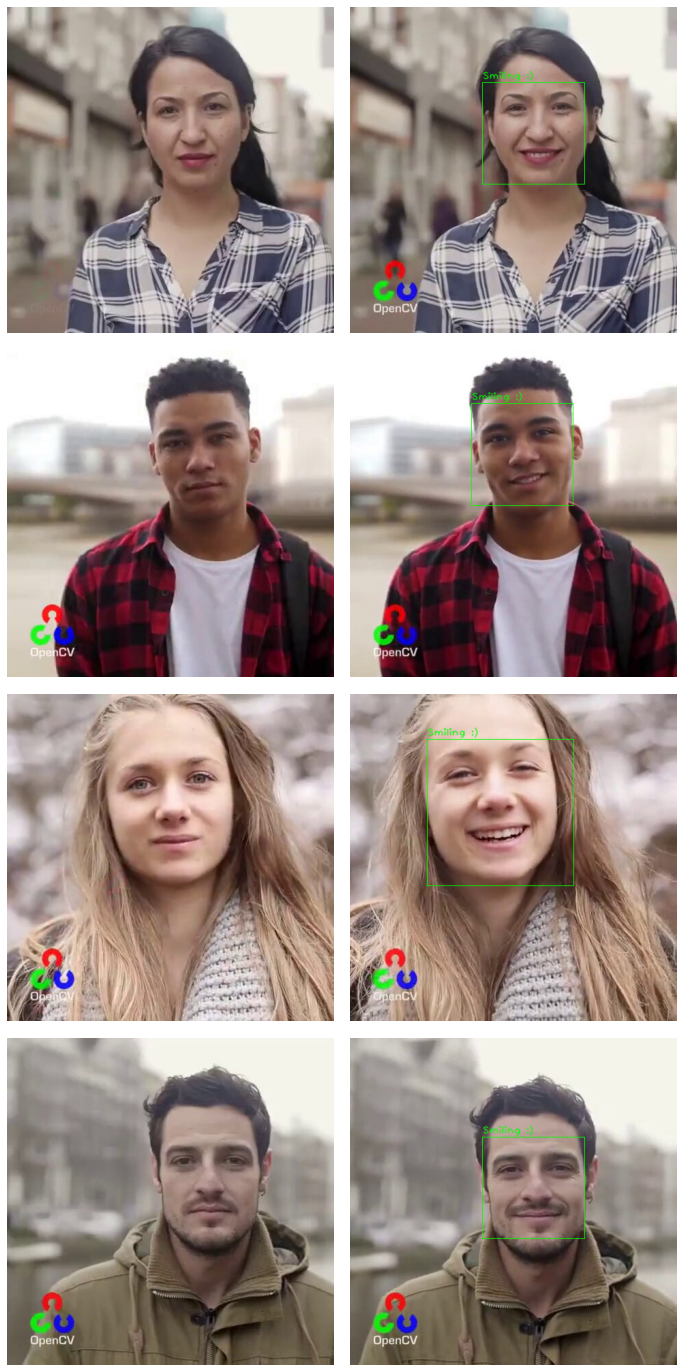

In [58]:
n_per_row = 2 
fig, axes = plt.subplots(nrows= n//n_per_row + (n%n_per_row>0), ncols=n_per_row, figsize=(12,25))
for index, file in enumerate(image_files):
    im = cv2.imread(image_path + '/' + file)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    smiling_faces = smile_detector.detect(im_rgb)
    im_rgb = smile_detector.draw_result(im_rgb, smiling_faces)
    axes[index//n_per_row, index%n_per_row].imshow(im_rgb)
    axes[index//n_per_row, index%n_per_row].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)

### Test detector with video file

In [5]:
# From: video processing script from OpenCV.org Computer Vision II course

# Initializing video capture object.
capture = cv2.VideoCapture("./videos/smile.mp4")
if(False == capture.isOpened()):
    print("[ERROR] Video not opened properly")    

# Create a VideoWriter object
smileDetectionOut = cv2.VideoWriter("smileDetectionOutput.avi",
                                   cv2.VideoWriter_fourcc('M','J','P','G'),
                                   15,(int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), 
                                       int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    
frame_number = 0
smile_frames = []
while (True):
    # grab the next frame
    isGrabbed, frame = capture.read()
    if not isGrabbed:
        break
        
    imDlib = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_has_smile = smile_detector.isSmiling(imDlib)
    if (True == frame_has_smile):
        cv2.putText(frame, "Smiling :)", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, cv2.LINE_AA)
        smile_frames.append(frame_number)
#         print("Smile detected in Frame# {}".format(frame_number))
    if frame_number % 50 == 0:
        print('\nProcessed {} frames'.format(frame_number))
        print("Smile detected in Frames: {}".format(smile_frames))
    # Write to VideoWriter
    smileDetectionOut.write(frame)
    
    frame_number += 1

capture.release()
smileDetectionOut.release()


Processed 0 frames
Smile detected in Frames: []

Processed 50 frames
Smile detected in Frames: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

Processed 100 frames
Smile detected in Frames: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

Processed 150 frames
Smile detected in Frames: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 